Group members:


-   Ceccon Gioele - 2079425
-   Nardella Gaia - 2091413
-   Renna Pietro - 2089068
-   Rocca Valerio - 2094861



# Imports

In [131]:
from xml.dom import pulldom
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
import time 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

# Part 1

## Point Generation

We decided to generate 10000 points: 


1.   5000 belong to class 1 
2.   5000 belong to class -1

In total, only 5% of the samples (equally divided among the two classes) have their true labeled assigned. 



In [132]:
random.seed(123)
n_points = 100

In [133]:
def generate_points(n_points=n_points, weights = [0.25, 0.25, 0.25, 0.25]):
    # Define the means and covariance matrices for the four clusters
    cluster_params = [
        {
            'mean': np.array([-2, 0]),
            'cov': np.array([[7, 0], [0, 0.5]])
        },
        {
            'mean': np.array([2, 4]),
            'cov': np.array([[0.5, 0], [0, 4]])
        },
        {
            'mean': np.array([2, 11]),
            'cov': np.array([[7, 0], [0, 0.5]])
        },
        {
            'mean': np.array([-2, 7]),
            'cov': np.array([[0.5, 0], [0, 4]])
        }
    ]

    samples = np.empty((0, 3))

    #giro sui cluster
    for i, cluster in enumerate(cluster_params):
        # Estraggo punti
        sample = np.random.multivariate_normal(cluster['mean'], cluster['cov'], int(n_points*weights[i]))
        # Se i punti sono stati estratti dai primi due cluster, assegno ai punti label 1.
        # Se i punti sono stati estratti dagli altri due cluster, assegno ai punti label -1
        if i==0 or i==1:
            label=1
        elif i==2 or i==3:
            label =-1
        
        # np.full() is a NumPy function that creates a new array of a specified shape and fills it with a given scalar value (label)
        # The axis=1 argument tells np.concatenate() to concatenate the arrays horizontally (i.e., by adding columns), so that the label
        # column is added to the right of the sample array.
        sample = np.concatenate((sample, np.full((sample.shape[0], 1), label)), axis=1)
        #unisco tutti i punti dei 4 cluster in un unico array che per ogni elemento ha [cordinata x, cordinata y, label]
        samples = np.concatenate((samples, sample))
    
    true_unlabel = np.array([])

    for i in range(len(samples)):
        # after 19 points I get a labeled point, I set label equal to zero in other points (we know label of only 5% of points)
        if i % 20 != 0.0:
            true_unlabel = np.append(true_unlabel, samples[i][2])
            samples[i][2] = 0

    # Split the samples based on their class label
    unlabeled = samples[samples[:, 2] == 0]
    class1= samples[samples[:, 2] == 1]
    class2 = samples[samples[:, 2] == -1]
    labeled = np.concatenate((class1,class2))

    return unlabeled, class1, class2, labeled, true_unlabel  # restituisce una tupla

In [134]:
samples = generate_points()
unlabeled_samples = samples[0]
class1_samples = samples[1]
class2_samples = samples[2]
labeled_samples = samples[3]
true_unlabeled_samples = samples[4]

print(f"There are 1000 points where {class1_samples.shape[0]} belong to class 1 and {class1_samples.shape[0]} belong to class -1. {unlabeled_samples.shape[0]} samples are unlabeled and {labeled_samples.shape[0]} are labeled ({np.round(((labeled_samples.shape[0]/n_points)*100),1)}% of the total.)")

There are 1000 points where 3 belong to class 1 and 3 belong to class -1. 95 samples are unlabeled and 5 are labeled (5.0% of the total.)


In [135]:
# CREATION OF THE INDEX OF THE COLUMN OF THE LABELS
index_lab = 2

In [136]:
def generate_random_labels(unlabeled, ind_lab):
    # Assign random label to unlabeled units

    random_labels=np.random.choice([-1, 1], size=np.shape(unlabeled)[0], p=[0.5, 0.5])
    random_labels_samples = np.concatenate((unlabeled[:,0:(ind_lab)], np.reshape(random_labels, (-1, 1))), axis=1)

    return random_labels_samples

In [137]:
random_unlabeled_samples = generate_random_labels(unlabeled_samples, index_lab)

print(f"First labels initialization: {random_unlabeled_samples}")

First labels initialization: [[-2.65097856e+00 -9.60984742e-02  1.00000000e+00]
 [-3.77181348e+00 -2.20256242e-01 -1.00000000e+00]
 [ 1.54969381e-02 -5.83543230e-01  1.00000000e+00]
 [-8.65785390e-01  7.94796530e-01  1.00000000e+00]
 [-2.67965460e+00  1.56219375e-01  1.00000000e+00]
 [-3.37441834e+00 -5.95118924e-01 -1.00000000e+00]
 [-1.20046101e+00  3.20055522e-03  1.00000000e+00]
 [-2.67149203e+00 -1.62638169e-02  1.00000000e+00]
 [-1.69656025e+00 -4.89695868e-01  1.00000000e+00]
 [-3.78962609e+00  1.40443352e+00  1.00000000e+00]
 [-2.70137039e-01  2.04568470e-01 -1.00000000e+00]
 [-5.53632748e+00 -1.49427071e+00  1.00000000e+00]
 [-3.96099941e+00 -2.15492658e-01  1.00000000e+00]
 [-1.65074505e+00 -1.80656254e+00  1.00000000e+00]
 [-4.43353661e-01  2.41354933e-01  1.00000000e+00]
 [-5.15991795e+00 -4.56059251e-01  1.00000000e+00]
 [-4.73636680e+00 -3.12424323e-01  1.00000000e+00]
 [-3.34664624e+00 -1.46196763e-01  1.00000000e+00]
 [ 4.08919012e-02 -6.68971035e-01 -1.00000000e+00]
 [

In [138]:
def plot_points(unlabeled_samples, class1_samples, class2_samples):
    # Plot the samples of each class with a different color and marker
    plt.scatter(unlabeled_samples[:, 0], unlabeled_samples[:, 1], color='grey', label='Unlabeled', alpha=0.7)
    plt.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.7)
    plt.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.7)

    # Add legend and axis labels
    plt.legend()
    plt.xlabel('X_1')
    plt.ylabel('X_2')

    # Show the plot
    plt.show()

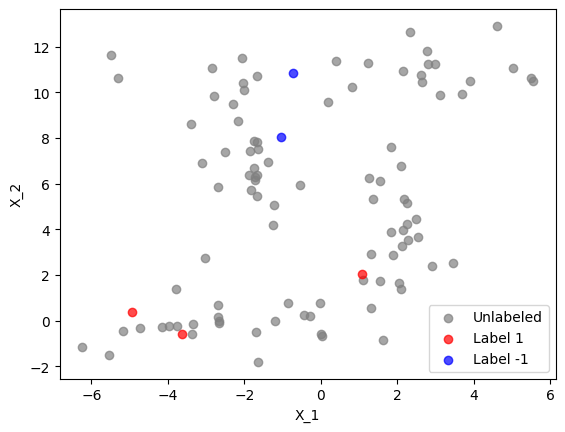

In [139]:
plot_points(unlabeled_samples, class1_samples, class2_samples)

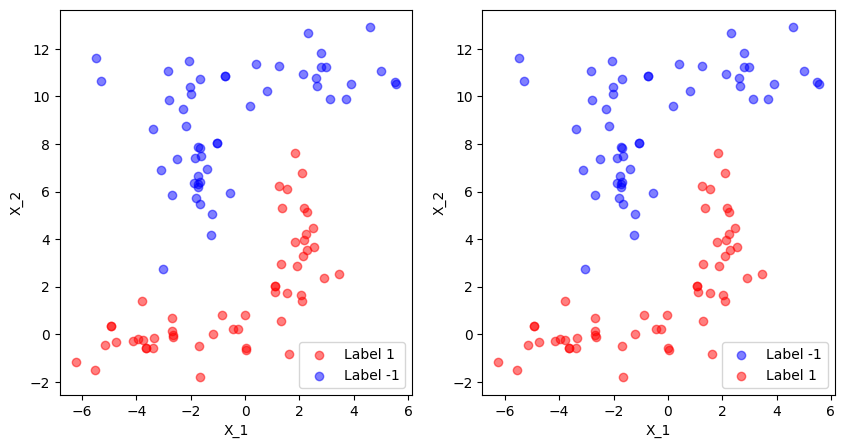

In [140]:
true_samples = np.concatenate((labeled_samples,unlabeled_samples))

k = 0
for i in range(len(true_samples)):
  if true_samples[i,2] == 0:
    true_samples[i,2] = true_unlabeled_samples[k]
    k += 1

positive = true_samples[(true_samples[:, 2] == 1)]  # matrix with unlab samples having true lab 1
negative = true_samples[(true_samples[:, 2] == -1)] # matrix with unlab samples having true lab -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: positive and negative samples
ax1.scatter(positive[:, 0], positive[:, 1], color='red', alpha=0.5)
ax1.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.5)
ax1.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.5)
ax1.scatter(negative[:, 0], negative[:, 1], color='blue', alpha=0.5)

ax1.legend()
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')

# Plot 2: negative and positive samples
ax2.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.5)
ax2.scatter(negative[:, 0], negative[:, 1], color='blue', alpha=0.5)
ax2.scatter(positive[:, 0], positive[:, 1], color='red', alpha=0.5)
ax2.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.5)

ax2.legend()
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')

# Show the plot
plt.show()

## Similarity function and weights computation

Since the points are drawn from a 2D space, we choose to adopt theinverse multiquadratic kernel as similarity function:

$$ K(x, y) = \frac{1}{\sqrt{c^2 + ||x - y||^2}} $$

In [141]:
def inverse_multiquadratic_kernel(p1, p2, sigma=0.02):
    """
    Computes the inverse multiquadratic kernel between two 2D points.

    Args:
    p1: A numpy array of shape (2,) containing the first 2D point.
    p2: A numpy array of shape (2,) containing the second 2D point.
    c: A scalar value that controls the strength of the kernel.

    Returns:
    A scalar value representing the inverse multiquadratic kernel between the two points.
    """
    # Compute the Euclidean distance between the points
    dist = np.sqrt(np.sum((p1 - p2) ** 2))

    # Compute the inverse multiquadratic kernel
    #kernel = 1.0 / np.sqrt(dist ** 2 + c ** 2)

    # Compute the Laplacian Kernel
    kernel = np.exp(-dist**2 / sigma)

    return kernel

In [142]:
# similarity matrix unlabeled-labeled
def similarity_matrix(unlabeled, labeled, ind_lab):

  W = np.zeros((np.shape(unlabeled)[0], np.shape(labeled)[0]))
  W_bar = np.zeros((np.shape(unlabeled)[0], np.shape(unlabeled)[0]))

  # similarity matrix unlabeled-labeled
  for row in range(np.shape(W)[0]):
      for col in range(np.shape(W)[1]): 
          W[row, col] = inverse_multiquadratic_kernel(unlabeled[row, :ind_lab],labeled[col, :ind_lab])

  # similarity matrix unlabeled-unlabeled
  for row in range(np.shape(W_bar)[0]):
      for col in range(np.shape(W_bar)[1]):
          W_bar[row, col] = inverse_multiquadratic_kernel(unlabeled[row, :ind_lab],unlabeled[col, :ind_lab])

  return W, W_bar

In [143]:
weights = similarity_matrix(unlabeled_samples, labeled_samples, index_lab)
w=weights[0]
w_bar=weights[1]

## Lipschitz constant

If f is twice continuously differentiable, then the Lipschitz constant can be estimated as the maximum eigenvalue of the Hessian matrix $\nabla^2 f$ at any point in the domain of f. Specifically, the Lipschitz constant L is given by:
$$ L = \|\nabla^2 f(x)\| $$

Thus, we can use the maximum eigenvalue of $\nabla^2 f$ to estimate L.

In this problem, the Hessian matrix is a diagonal matrix positive-definite.

In [144]:
def compute_L(u_samples, w=w, w_bar=w_bar):
  dim = np.shape(u_samples)[0]
  h = np.zeros((dim,dim))

  for i in range(dim):
    h[i,i] = 2 * (np.sum(w[i,:]) + np.sum(w_bar[i,:]))

  eigenvalues = np.linalg.eigvals(h)
  return np.max(np.abs(eigenvalues))

In [145]:
L = compute_L(unlabeled_samples)
print(L)

4.383855036313563


## Gradient Methods

First of all we define some constants and functions that will be used by the algorithms:

In [146]:
epsilon = 1e-5      # Threshold for the stopping condition
epochs = 50         # Max number of iterations
check = 3           # Used to retrieve informations about the behavior of the algorithm every check iterations

In [147]:
# Threshold selector
def threshold_sel(y_lab_norm):
    y_lab_out = np.copy(y_lab_norm)
    y_lab_out[y_lab_out < 0] = -1
    y_lab_out[y_lab_out >= 0] = 1
    
    return y_lab_out

In [148]:
# Accuracy function
def get_accuracy(y):
  y_out = threshold_sel(y)

  return accuracy_score(true_unlabeled_samples, y_out)

In [149]:
# Plot the missclassified and correctly classified units
def miss_plot(unlab_grad, unlab_samples = unlabeled_samples, unlab_true = true_unlabeled_samples):
  # Output labels
  unlab_labs = threshold_sel(unlab_grad)
  
  # Split in two matrices to plot
  for i in range(np.shape(unlab_samples)[0]):
    unlab_samples[i,2] = unlab_labs[i]
  unlab_true = np.array(unlab_true)

  unlab_samples_tp = unlab_samples[(unlab_samples[:, 2] == 1) & (unlab_samples[:, 2] == unlab_true)]
  unlab_samples_tn = unlab_samples[(unlab_samples[:, 2] == -1) & (unlab_samples[:, 2] == unlab_true)]
  unlab_samples_fp = unlab_samples[(unlab_samples[:, 2] == 1) & (unlab_samples[:, 2] != unlab_true)]
  unlab_samples_fn = unlab_samples[(unlab_samples[:, 2] == -1) & (unlab_samples[:, 2] != unlab_true)]
  
  # Plot the samples of each class with a different color and marker
  plt.scatter(unlab_samples_tp[:, 0], unlab_samples_tp[:, 1], color='red', label='True 1', alpha=0.7)
  plt.scatter(unlab_samples_tn[:, 0], unlab_samples_tn[:, 1], color='blue', label='True -1', alpha=0.7)
  plt.scatter(unlab_samples_fp[:, 0], unlab_samples_fp[:, 1], color='orange', label='False 1', alpha=0.7)
  plt.scatter(unlab_samples_fn[:, 0], unlab_samples_fn[:, 1], color='cyan', label='False -1', alpha=0.7)

  # Add legend and axis labels
  plt.legend()
  plt.xlabel('X_1')
  plt.ylabel('X_2')

  # Show the plot
  return(plt.show())


In [150]:
# Plot accuracy vs epochs
def acc_epochs_plot(result_list, check=check):

  epochs_array = np.arange(0, check * len(result_list), check)
  
  plt.plot(epochs_array, result_list, marker = ".")

  # Set the plot title and labels
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

In [151]:
# Plot accuracy vs time
def acc_time_plot(result_list, time_list):
  plt.plot(time_list, result_list, marker = ".")

  # Set the plot title and labels
  plt.title('Accuracy vs Time')
  plt.xlabel('Elapsed Time (seconds)')
  plt.ylabel('Accuracy')


### Gradient Descent

In [152]:
def gradient(lab_samples, unlab_samples, ind_lab, w=w, w_bar=w_bar):
    grads = []
    for j in range(np.shape(unlab_samples)[0]):
        grad = 0
        for i in range(np.shape(lab_samples)[0]):
            grad += 2 * w[j][i] * (unlab_samples[j][ind_lab] - lab_samples[i][ind_lab])
        for i in range(np.shape(unlab_samples)[0]):
            grad += w_bar[j][i] * (unlab_samples[j][ind_lab] - unlab_samples[i][ind_lab])
        grads.append(grad) #/ (np.shape(lab_samples)[0] + np.shape(unlab_samples)[0])) #GRADIENT+NORMALIZATION

    return np.array(grads)

In [153]:
def gradient_descent(lab_samples, unlab_samples, ind_lab, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.process_time()

    for i in range(epochs):
        grads = gradient(lab_samples, y_lab, ind_lab, w, w_bar)

        norm = np.linalg.norm(grads)
        if  norm < epsilon:
          print(f"The norm of the gradient at iteration {i} is: {norm}") 
          break

        y_lab[:,ind_lab] -= alpha * grads
        

        if(i % check == 0):
          print(f"The norm of the gradient at iteration {i} is: {norm}")

          acc_list.append(get_accuracy(y_lab[:,ind_lab]))

          elapsed_time = time.process_time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,ind_lab], np.array(acc_list), np.array(time_list)

In [154]:
check_gd = 3    # Customzied check constant for the basic GD algorithm

In [155]:
%%time
y_lab_gd, acc_list_gd, time_list_gd = gradient_descent(labeled_samples, random_unlabeled_samples, index_lab, check = check_gd)

print(f"\nAccuracy for Gradient Descent: {get_accuracy(y_lab_gd)}")

print("\nNumber of 1 in Gradient Descent {}".format(np.sum(threshold_sel(y_lab_gd) == 1) / len(y_lab_gd)))
print("Number of -1 in Gradient Descent {}\n".format(np.sum(threshold_sel(y_lab_gd) == -1) / len(y_lab_gd)))


The norm of the gradient at iteration 0 is: 3.27493155686918
The norm of the gradient at iteration 2 is: 1.683973247059031
The norm of the gradient at iteration 4 is: 1.0570716027950322
The norm of the gradient at iteration 6 is: 0.7829985409021137
The norm of the gradient at iteration 8 is: 0.630608987221079
The norm of the gradient at iteration 10 is: 0.5265292192997649
The norm of the gradient at iteration 12 is: 0.44816325302670096
The norm of the gradient at iteration 14 is: 0.387051441761238
The norm of the gradient at iteration 16 is: 0.3388056171159185
The norm of the gradient at iteration 18 is: 0.30048205195187633
The norm of the gradient at iteration 20 is: 0.2698544801057001
The norm of the gradient at iteration 22 is: 0.2451756549588522
The norm of the gradient at iteration 24 is: 0.225070462610717
The norm of the gradient at iteration 26 is: 0.20846705895177645
The norm of the gradient at iteration 28 is: 0.1945409746511019
The norm of the gradient at iteration 30 is: 0.1

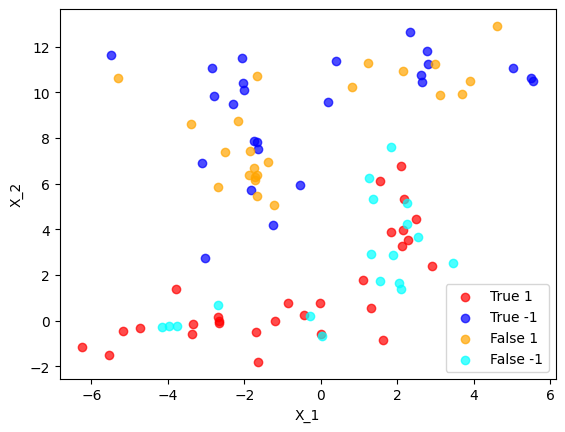

In [156]:
miss_plot(y_lab_gd)

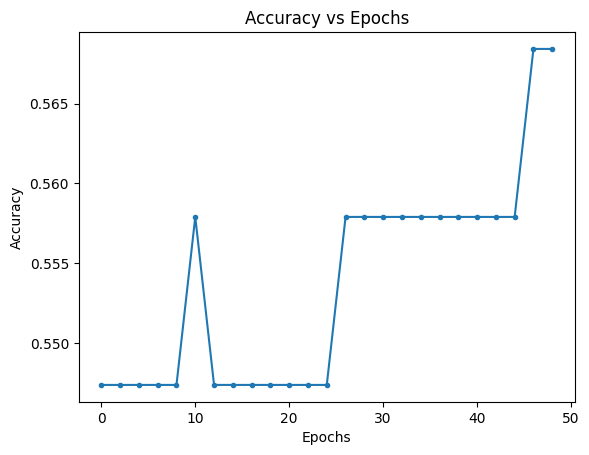

In [157]:
acc_epochs_plot(acc_list_gd, check = check_gd)

In [158]:
#acc_time_plot(acc_list_gd, time_list_gd)

### Randomized BCGD

In [159]:
def rand_gradient(lab_samples, unlab_samples, ind_lab, W=w, W_bar=w_bar):
    grads = np.zeros(np.shape(unlab_samples)[0])
    j = np.random.randint(0, np.shape(unlab_samples)[0])
    j = int(j)
    grad = 0
    for i in range(np.shape(lab_samples)[0]):
        grad += 2 * W[j][i] * (unlab_samples[j][ind_lab] - lab_samples[i][ind_lab])
    for i in range(np.shape(unlab_samples)[0]):
        grad += W_bar[j][i] * (unlab_samples[j][ind_lab] - unlab_samples[i][ind_lab])
    grads[j] = grad  # / (np.shape(lab_samples)[0] + np.shape(unlab_samples)[0])
    return grads

In [160]:
def rand_bcgd(lab_samples, unlab_samples, ind_lab, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.process_time()

    for i in range(epochs):
        grads = rand_gradient(lab_samples, y_lab, ind_lab, w, w_bar)

        norm = np.linalg.norm(grads)
        if  norm < epsilon: 
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          break

        y_lab[:, ind_lab] -= alpha * grads

        if(i % check == 0):
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          acc_list.append(get_accuracy(y_lab[:,ind_lab]))
          elapsed_time = time.process_time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,ind_lab], acc_list, time_list

In [161]:
epochs_random = 60000  # Customzied epochs constant for the Randomized BCGD algorithm
check_random = 3000     # Customzied check constant for the Randomized BCGD algorithm

In [162]:
%%time
y_lab_rand_bcgd, acc_list_rand_bcgd, time_list_rand_bcgd = rand_bcgd(labeled_samples, random_unlabeled_samples, index_lab, epochs = epochs_random, check = check_random)

print(f"\nAccuracy for Randomized BCGD: {get_accuracy(y_lab_rand_bcgd)}")

print("\nFrequency of 1 in Randomized BCGD {}".format(np.sum(threshold_sel(y_lab_rand_bcgd) == 1) / len(y_lab_rand_bcgd)))
print("Frequency of -1 in Randomized BCGD {}\n".format(np.sum(threshold_sel(y_lab_rand_bcgd) == -1) / len(y_lab_rand_bcgd)))


The norm of the gradient at iteration 0 is: 2.42971136655046e-06

Accuracy for Randomized BCGD: 0.5473684210526316

Frequency of 1 in Randomized BCGD 0.5473684210526316
Frequency of -1 in Randomized BCGD 0.45263157894736844

CPU times: total: 15.6 ms
Wall time: 3 ms


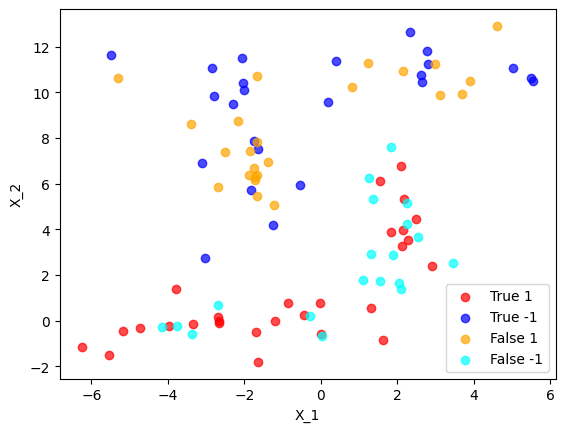

In [163]:
miss_plot(y_lab_rand_bcgd)

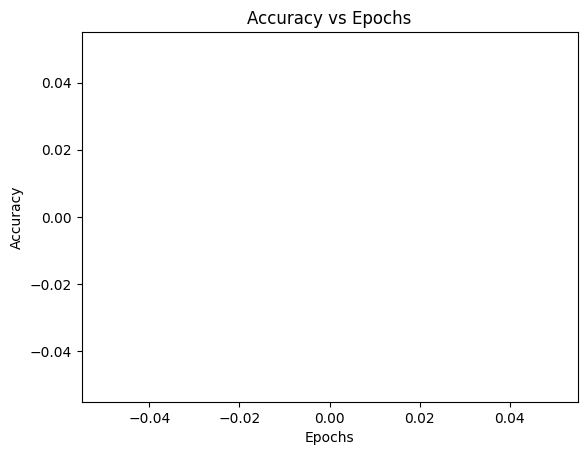

In [164]:
acc_epochs_plot(acc_list_rand_bcgd, check = check_random)

In [165]:
#acc_time_plot(acc_list_rand_bcgd, time_list_rand_bcgd)

### Gauss-Southwell BCGD

In [166]:
def gs_gradient(lab_samples, unlab_samples, index, ind_lab, step_size, old_gradient, W=w, W_bar=w_bar):
  
  update = np.zeros(len(unlab_samples))
  grad = 0
  for i in range(np.shape(lab_samples)[0]):
    grad += 2 * W[index][i] * (unlab_samples[index][ind_lab] - lab_samples[i][ind_lab])
  for i in range(np.shape(unlab_samples)[0]):
    grad += W_bar[index][i] * (unlab_samples[index][ind_lab] - unlab_samples[i][ind_lab])
  
  update[index] = grad

  unlab_samples[:, ind_lab] += -step_size * update

  grad = 0
  for i in range(np.shape(lab_samples)[0]):
    grad += 2 * W[index][i] * (unlab_samples[index][ind_lab] - lab_samples[i][ind_lab])
  for i in range(np.shape(unlab_samples)[0]):
    grad += W_bar[index][i] * (unlab_samples[index][ind_lab] - unlab_samples[i][ind_lab])
  
  old_gradient[index] = grad 


  return unlab_samples[:,ind_lab], old_gradient

In [167]:
def gs_bcgd(lab_samples, unlab_samples, ind_lab, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.process_time()

    grad = gradient(lab_samples, unlab_samples, ind_lab, w, w_bar)

    for i in range(epochs):

      norm = np.linalg.norm(grad)
      if  norm < epsilon:
        print(f"The norm of the gradient at iteration {i} is: {norm}") 
        break
      
      j = np.argmax(np.abs(grad))

      y_lab[:, ind_lab], grad = gs_gradient(lab_samples, y_lab, j, ind_lab, alpha, grad, w, w_bar)

      if(i % check == 0):
        print(f"The norm of the gradient at iteration {i} is: {norm}")
        acc_list.append(get_accuracy(y_lab[:,ind_lab]))
        elapsed_time = time.process_time() - start_time
        time_list.append(elapsed_time)

    return y_lab[:,ind_lab], acc_list, time_list

In [168]:
epochs_gs = 25000  # Customzied epochs constant for the Randomized BCGD algorithm
check_gs = 1250     # Customzied check constant for the Randomized BCGD algorithm

In [169]:
%%time
y_lab_gs_bcgd, y_list_gs_bcgd, time_list_gs_bcgd = gs_bcgd(labeled_samples, random_unlabeled_samples, index_lab, epochs = epochs_gs, check = check_gs)

print(f"\nAccuracy for Gauss-Southwell BCGD: {get_accuracy(y_lab_gs_bcgd)}")

print("\nFrequency of 1 in Gauss Sauthwell BCGD {}".format(np.sum(threshold_sel(y_lab_gs_bcgd) == 1) / len(y_lab_gs_bcgd)))
print("Frequency of -1 in Gauss Sauthwell BCGD {}\n".format(np.sum(threshold_sel(y_lab_gs_bcgd) == -1) / len(y_lab_gs_bcgd)))

The norm of the gradient at iteration 0 is: 3.27493155686918

Accuracy for Gauss-Southwell BCGD: 0.5473684210526316

Frequency of 1 in Gauss Sauthwell BCGD 0.5263157894736842
Frequency of -1 in Gauss Sauthwell BCGD 0.47368421052631576

CPU times: total: 203 ms
Wall time: 174 ms


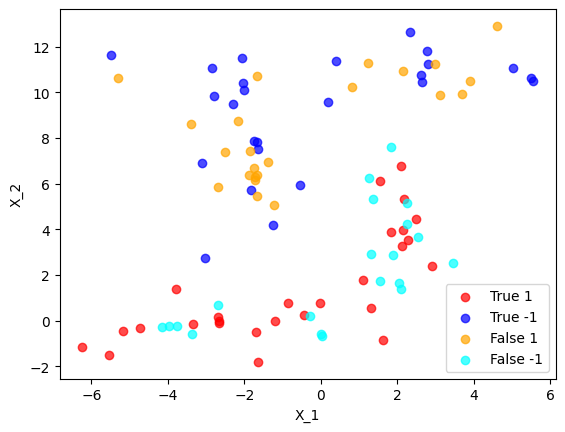

In [170]:
miss_plot(y_lab_gs_bcgd)

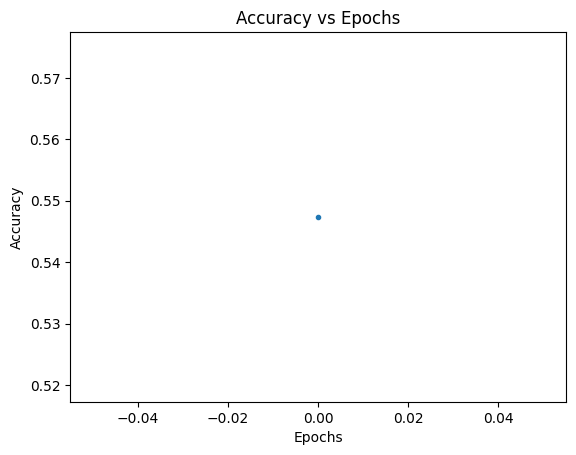

In [171]:
acc_epochs_plot(y_list_gs_bcgd, check = check_gs)

# Part 2

In [172]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt
#!wget kaggle datasets download -d jsphyg/weather-dataset-rattle-package

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [173]:
# Load the dataset into a Pandas DataFrame
#df = pd.read_csv('C:\\Users\\valer\\Desktop\\Optimization\\hw_1\\Optimization-HW1\\weatherAUS.csv', header=0)

# Normalize the features in the small set
#scaler = MinMaxScaler()
#df[['variance', 'skewness', 'curtosis', 'entropy', 'class']] = scaler.fit_transform(df[['variance', 'skewness', 'curtosis', 'entropy']])

# Replace 0 with -1 in the 'class' column
#df['class'] = df['class'].replace(0, -1)

#df = df[(df['Location'] == 'SydneyAirport') | (df['Location'] == 'Sydney')]
#df = df.dropna()
#df = df[['MinTemp', 'MaxTemp', 'Evaporation', 'Rainfall', 'WindGustSpeed', 'Sunshine', 'RainTomorrow']]
#y_place = df[['RainTomorrow']]
#X_place = df[['MinTemp', 'MaxTemp', 'Evaporation', 'Rainfall', 'WindGustSpeed', 'Sunshine']]
#X_place, y_place = RandomUnderSampler().fit_resample(X_place, y_place)
#df = np.concatenate((X_place, y_place), axis = 1)
#df = pd.DataFrame(df)
#df.columns = ['MinTemp', 'MaxTemp', 'Evaporation', 'Rainfall', 'WindGustSpeed', 'Sunshine', 'RainTomorrow']
#print(f"The dimensionality now is: {np.shape(df)}")                                                 

# Replace 0 with -1 in the 'class' column
#df['RainTomorrow'] = df['RainTomorrow'].replace('No', -1)
#df['RainTomorrow'] = df['RainTomorrow'].replace('Yes', 1)

# Display the first few rows of the DataFrame
#print(df)



In [174]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', header=None, names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])

# Normalize the features in the small set
scaler = MinMaxScaler()
df[['variance', 'skewness', 'curtosis', 'entropy']] = scaler.fit_transform(df[['variance', 'skewness', 'curtosis', 'entropy']])

# Replace 0 with -1 in the 'class' column
df['class'] = df['class'].replace(0, -1)

# Display the first few rows of the DataFrame
print(df.head())

   variance  skewness  curtosis   entropy  class
0  0.769004  0.839643  0.106783  0.736628     -1
1  0.835659  0.820982  0.121804  0.644326     -1
2  0.786629  0.416648  0.310608  0.786951     -1
3  0.757105  0.871699  0.054921  0.450440     -1
4  0.531578  0.348662  0.424662  0.687362     -1


In [175]:
# Extract the features and target variable
#X = df.drop('RainTomorrow', axis=1)
#y = df['RainTomorrow']

# Fit a PCA transformer to the features
#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X)

# Print the explained variance ratios of the principal components
#print(pca.explained_variance_ratio_)

In [176]:
# Convert the NumPy array to a Pandas Series
#series = pd.Series(random_unlabeled_samples)

# Get the frequency table using value_counts()
#frequency_table = series.value_counts()

# Print the frequency table
#print(frequency_table)

In [177]:
# 762 -1, 610 1 --> 45% class 1, 55% class -1
#labels = np.array(df['RainTomorrow'].values)

# 762 -1, 610 1 --> 45% class 1, 55% class -1
labels = np.array(df['class'].values)

In [178]:
# Split the dataset into two sets, one with 5% of the examples and the other with 95% of the examples
#large_set, small_set = train_test_split(df, test_size=0.05, stratify=df['RainTomorrow'])
#print(f'Size of small set: {len(small_set)}')
#print(f'Size of large set: {len(large_set)}')

# Split the dataset into two sets, one with 5% of the examples and the other with 95% of the examples
large_set, small_set = train_test_split(df, test_size=0.05, stratify=df['class'])
print(f'Size of small set: {len(small_set)}')
print(f'Size of large set: {len(large_set)}')

Size of small set: 69
Size of large set: 1303


In [179]:
#true_unlabeled_samples = np.array(large_set['RainTomorrow'].values)

true_unlabeled_samples = np.array(large_set['class'].values)

In [180]:
# Set the class variable to 0 for all examples in the large set
#large_set.loc[:, 'RainTomorrow'] = 0
large_set.loc[:, 'class'] = 0

In [181]:
#unlabeled_samples = large_set.to_numpy()
#labeled_samples = small_set.to_numpy()

unlabeled_samples = large_set.to_numpy()
labeled_samples = small_set.to_numpy()

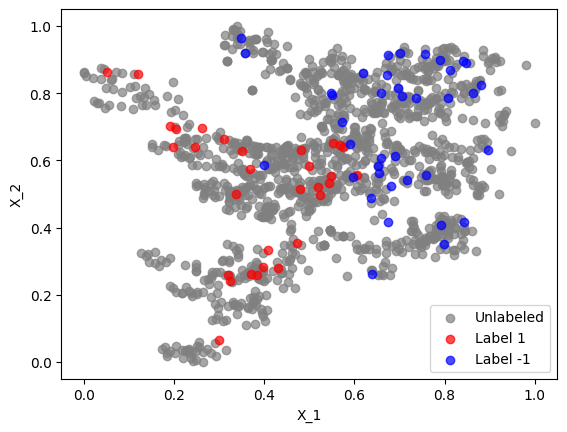

In [182]:
plot_points(unlabeled_samples,labeled_samples[labeled_samples[:, -1] == 1], labeled_samples[labeled_samples[:, -1] == -1])

In [183]:
index_lab = 4
random_unlabeled_samples = generate_random_labels(unlabeled_samples, index_lab)

In [184]:
weights = similarity_matrix(unlabeled_samples, labeled_samples, index_lab)
w=weights[0]
w_bar=weights[1]

In [185]:
L = compute_L(unlabeled_samples, w, w_bar)
print(L)

204.4244531280724


In [186]:
# CLASSIC GRADIENT
epsilon = 1e-5      # Threshold for the stopping condition
epochs = 100        # Max number of iterations
check_gd = 5           # Used to retrieve informations about the behavior of the algorithm every check iterations

In [187]:
%%time
y_lab_gd, acc_list_gd, time_list_gd = gradient_descent(labeled_samples, random_unlabeled_samples, index_lab, alpha=1/L, check = check_gd, epochs = epochs, epsilon = epsilon)

print(f"\nAccuracy for Gradient Descent: {get_accuracy(y_lab_gd)}")

print("\nNumber of 1 in Gradient Descent {}".format(np.sum(threshold_sel(y_lab_gd) == 1) / len(y_lab_gd)))
print("Number of -1 in Gradient Descent {}\n".format(np.sum(threshold_sel(y_lab_gd) == -1) / len(y_lab_gd)))

The norm of the gradient at iteration 0 is: 2181.723624863396
The norm of the gradient at iteration 2 is: 968.5626539687131
The norm of the gradient at iteration 4 is: 510.5713278968564
The norm of the gradient at iteration 6 is: 315.16602243712634
The norm of the gradient at iteration 8 is: 221.16842756378898
The norm of the gradient at iteration 10 is: 169.9864652693738
The norm of the gradient at iteration 12 is: 138.5015369610152
The norm of the gradient at iteration 14 is: 116.99894100941995
The norm of the gradient at iteration 16 is: 101.10963569961622
The norm of the gradient at iteration 18 is: 88.70295724521854
The norm of the gradient at iteration 20 is: 78.6446016668089
The norm of the gradient at iteration 22 is: 70.27701649344597
The norm of the gradient at iteration 24 is: 63.188788635941805

Accuracy for Gradient Descent: 0.9378357636224098

Number of 1 in Gradient Descent 0.4604758250191865
Number of -1 in Gradient Descent 0.5395241749808135

CPU times: total: 20.6 s
W

In [188]:
# RANDOMIZED BCGD
epochs_random = 120000  # Customzied epochs constant for the Randomized BCGD algorithm
check_random = 6000     # Customzied check constant for the Randomized BCGD algorithm

In [189]:
%%time
y_lab_rand_bcgd, acc_list_rand_bcgd, time_list_rand_bcgd = rand_bcgd(labeled_samples, random_unlabeled_samples, index_lab, alpha=1/L, epochs = epochs_random, check = check_random, epsilon = epsilon)

print(f"\nAccuracy for Randomized BCGD: {get_accuracy(y_lab_rand_bcgd)}")

print("\nFrequency of 1 in Randomized BCGD {}".format(np.sum(threshold_sel(y_lab_rand_bcgd) == 1) / len(y_lab_rand_bcgd)))
print("Frequency of -1 in Randomized BCGD {}\n".format(np.sum(threshold_sel(y_lab_rand_bcgd) == -1) / len(y_lab_rand_bcgd)))

The norm of the gradient at iteration 0 is: 59.87647255056063
The norm of the gradient at iteration 2500 is: 28.26247609383807
The norm of the gradient at iteration 5000 is: 48.11887970594873
The norm of the gradient at iteration 7500 is: 10.560062385142619
The norm of the gradient at iteration 10000 is: 4.5302029419185965
The norm of the gradient at iteration 12500 is: 3.705116197460018
The norm of the gradient at iteration 15000 is: 7.453681938935622
The norm of the gradient at iteration 17500 is: 1.4765553429042124
The norm of the gradient at iteration 20000 is: 1.9222282615257895
The norm of the gradient at iteration 22500 is: 3.8692275984448687

Accuracy for Randomized BCGD: 0.9171143514965464

Frequency of 1 in Randomized BCGD 0.4535686876438987
Frequency of -1 in Randomized BCGD 0.5464313123561013

CPU times: total: 17 s
Wall time: 1min 2s


In [190]:
# G-S BCGD
epochs_gs = 50000  # Customzied epochs constant for the Randomized BCGD algorithm
check_gs = 2500    # Customzied check constant for the Randomized BCGD algorithm

In [191]:
%%time
y_lab_gs_bcgd, acc_list_gs_bcgd, time_list_gs_bcgd = gs_bcgd(labeled_samples, random_unlabeled_samples, index_lab, alpha=1/L, epochs = epochs_gs, check = check_gs, epsilon = epsilon)

print(f"\nAccuracy for Gauss-Southwell BCGD: {get_accuracy(y_lab_gs_bcgd)}")

print("\nFrequency of 1 in Gauss Sauthwell BCGD {}".format(np.sum(threshold_sel(y_lab_gs_bcgd) == 1) / len(y_lab_gs_bcgd)))
print("Frequency of -1 in Gauss Sauthwell BCGD {}\n".format(np.sum(threshold_sel(y_lab_gs_bcgd) == -1) / len(y_lab_gs_bcgd)))

The norm of the gradient at iteration 0 is: 2181.723624863396
The norm of the gradient at iteration 2500 is: 842.6703255241522
The norm of the gradient at iteration 5000 is: 462.1382511745493
The norm of the gradient at iteration 7500 is: 292.143584974999

Accuracy for Gauss-Southwell BCGD: 0.9247889485801996

Frequency of 1 in Gauss Sauthwell BCGD 0.45203376822716806
Frequency of -1 in Gauss Sauthwell BCGD 0.5479662317728319

CPU times: total: 16.8 s
Wall time: 1min 4s


In [192]:
# Plot accuracy vs time
def acc_time_plot_global(result_list_gd, time_list_gd, result_list_rand, time_list_rand, result_list_gs, time_list_gs):
  plt.plot(time_list_gd, result_list_gd, marker = ".", label = "Classic GD")
  plt.plot(time_list_rand, result_list_rand, marker = ".", label = "Randomized BCGD")
  plt.plot(time_list_gs, result_list_gs, marker = ".", label = "G-S BCGD")

  # Set the plot title and labels
  plt.title('Accuracy vs Time')
  plt.xlabel('Elapsed Time (seconds)')
  plt.ylabel('Accuracy')
  plt.legend()

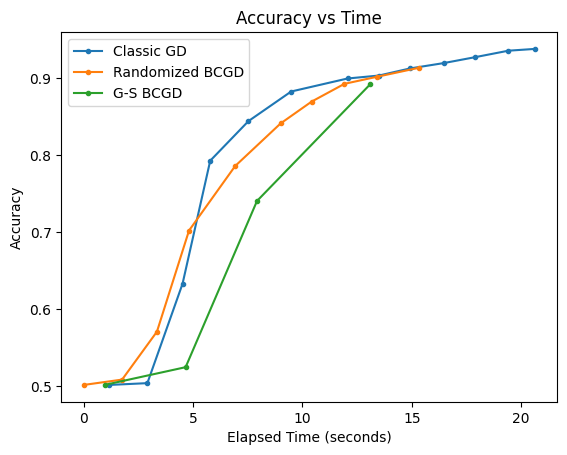

In [193]:
acc_time_plot_global(acc_list_gd, time_list_gd, acc_list_rand_bcgd, time_list_rand_bcgd, acc_list_gs_bcgd, time_list_gs_bcgd) 